In [1]:

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import config_enumerate
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Trace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.infer import Predictive
from torch.distributions import constraints

import pandas as pd
import matplotlib.pyplot as plt



# Simple mixture model using 'plate'


In [2]:

n_categories = 3

@config_enumerate
def model(data=None, n_data=None):
    assert (data is None) != (n_data is None)
    if n_data is None:
        n_data = data.shape[0]

    # Prior over categories
    probs = pyro.sample("probs", dist.Dirichlet(torch.ones([n_categories])))

    # Conditional distribution of the observed data
    means = torch.tensor([-2.0, 0.0, 2.0])  # Mean for each category
    scale = torch.tensor(0.25)  # Fixed standard deviation
    with pyro.plate("data", n_data):
        category = pyro.sample("category", dist.Categorical(probs))
        pyro.sample("obs", dist.Normal(means[category], scale), obs=data)



## Sample datapoints


tensor([0.1000, 0.5000, 0.4000])


<Axes: >

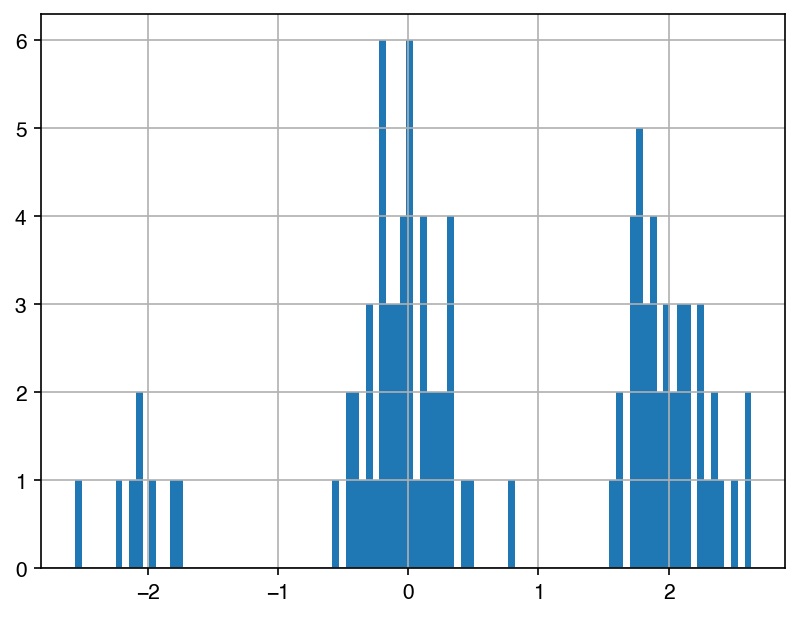

In [3]:

pyro.set_rng_seed(2022)
pyro.clear_param_store()

conditioned_model = pyro.poutine.condition(
    model,
    data={
        'probs': torch.tensor([0.1, 0.5, 0.4]),
    })

model_trace = pyro.poutine.trace(conditioned_model)

samples = model_trace.get_trace(n_data=100)

print(samples.nodes['probs']['value'].detach())

data = samples.nodes['obs']['value'].detach()

pd.Series(data).hist(bins=100)



## Inference with an AutoNormal guide



...............................................................................
...............................................................................
...............................................................................
...........................................................

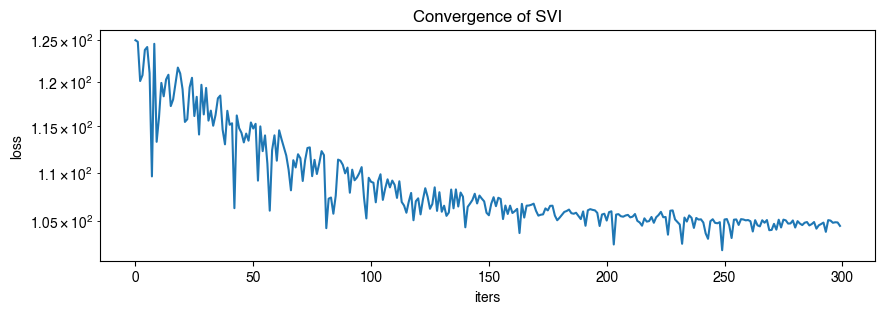

In [4]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)
guide = AutoNormal(pyro.poutine.block(model, expose=['probs']))
svi = SVI(model, guide, optim, loss=elbo)

pyro.clear_param_store()

losses = []
for i in range(300):
    loss = svi.step(data=data)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


In [5]:

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)(n_data=n_data)
predictive['probs'].mean(axis=0)


tensor([[0.0976, 0.4905, 0.4120]])


## Use a custom guide just for the categorical probs


In [6]:

def custom_guide(data=None, n_data=None):
    probs_posterior = pyro.param(
        'probs_posterior',
        lambda: torch.ones(n_categories),
    )

    probs = pyro.sample('probs', dist.Dirichlet(probs_posterior))



...............................................................................
...............................................................................
...............................................................................
...........................................................

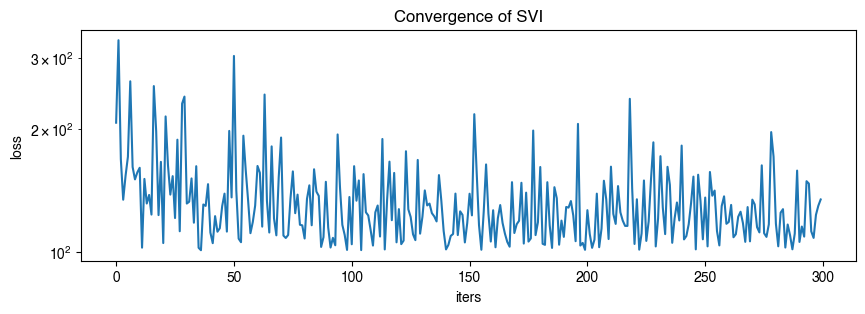

In [7]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)
svi = SVI(model, custom_guide, optim, loss=elbo)

pyro.clear_param_store()

losses = []
for i in range(300):
    loss = svi.step(data=data)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


In [8]:

num_samples = 1000
predictive = Predictive(model, guide=custom_guide, num_samples=num_samples)(n_data=n_data)
predictive['probs'].mean(axis=0)


tensor([[0.1546, 0.4460, 0.3994]])


# Explicit enumeration in the model


In [18]:

n_categories = 3
n_data = 100

def partially_vectorized_model(data=None, n_data=None):
    assert (data is None) != (n_data is None)
    if n_data is None:
        n_data = data.shape[0]

    # Prior over categories
    probs = pyro.sample("probs", dist.Dirichlet(torch.ones([n_categories])))

    # Conditional distribution of the observed data
    means = torch.tensor([-2.0, 0.0, 2.0])  # Mean for each category
    scale = torch.tensor(0.25)  # Fixed standard deviation

    for idx in range(n_data):
        # Vectorized computation of log probabilities for all categories
        cat_log_probs = dist.Categorical(probs).log_prob(torch.arange(n_categories))

        # Compute likelihood for each category
        if data is not None:
            instance_data = data[idx]
            obs_log_probs = dist.Normal(means, scale).log_prob(instance_data.unsqueeze(0).expand(n_categories))
        else:
            obs_log_probs = torch.zeros(n_categories)

        # Combine and sum log probabilities across categories
        total_log_prob = torch.logsumexp(cat_log_probs + obs_log_probs, dim=0)

        # Add the log probability for this data point to the model
        pyro.factor(f"total_log_prob_{idx}", total_log_prob)



## Inference with Trace_ELBO and 



...............................................................................
...............................................................................
...............................................................................
...........................................................

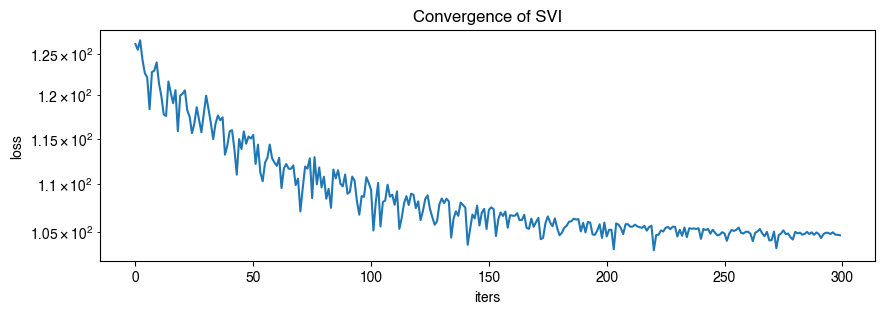

In [19]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=2)
guide = AutoNormal(pyro.poutine.block(partially_vectorized_model, expose=['probs'] + [f'scale_{idx}' for idx in range(n_data)]))
svi = SVI(partially_vectorized_model, guide, optim, loss=elbo)

pyro.clear_param_store()

losses = []
for i in range(300):
    loss = svi.step(data=data)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


In [20]:

num_samples = 1000
predictive = Predictive(partially_vectorized_model, guide=guide, num_samples=num_samples)(n_data=n_data)
predictive['probs'].mean(axis=0)


tensor([0.0950, 0.4896, 0.4154])